# Retinal Disease Detection and Classification

## By: Jalen Wu, Yechan Na, Jonathan Zhang

__Project Description:__

The goal of this project is to develop a machine learning model capable of detecting retinal diseases by analyzing fundus images of the eye. Using computer vision and deep learning techniques, the model assists in early detection and diagnosis of retinal disease(s).

__Applications and Impact:__

This project could be used for clinical screening to help ophthalmologists identify diseases and improve efficiency on identifying these diseases. This automated detection system has the potential to make medical imaging diagnostics more accessible.

__What we hope to achieve:__

We hope to build a model that takes in images of the eye and accurately predicts whether an individual’s eyes are healthy or showing signs of disease. To quantify the effectiveness of our model, we will be measuring metrics such as F1 score, precision, recall, loss, and accuracy of our models and graphing them as a function of how many epochs we run on our training data (all of these scores should increase in subsequent epochs).

- __Dataset__: https://www.kaggle.com/datasets/andrewmvd/retinal-disease-classification/data
- __References__: 
    - https://www.mdpi.com/2306-5729/6/2/14
    - https://jamanetwork.com/journals/jama/fullarticle/2588763
    

In [13]:
# imports

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
import os
from torch.utils.data import Dataset
import pandas as pd
from skimage import io, transform
from torch import tensor
from PIL import Image
from torch import flatten

In [14]:
# Import Dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/retinal-disease-classification")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Danie\.cache\kagglehub\datasets\andrewmvd\retinal-disease-classification\versions\1


In [15]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [52]:
# X = 1424 x 2144 x 3 : h x w x colors
# y = label
transform = transforms.Compose([
    transforms.Resize((int(1424 / 4), int(2144 / 4))), # Standardize image dimensions to 1424 x 2144
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

base_directory = path  
print(base_directory)

if os.path.exists(base_directory):
    print("Directory exists and its contents are:")
    print(os.listdir(base_directory))
else:
    print("Directory does not exist.")

C:\Users\Danie\.cache\kagglehub\datasets\andrewmvd\retinal-disease-classification\versions\1
Directory exists and its contents are:
['Evaluation_Set', 'Test_Set', 'Training_Set']


In [17]:
# Constants (paths that will be accessed later in the project)
BASE_DIRECTORY = path
TRAINING_DIRECTORY = os.path.join(BASE_DIRECTORY, 'Training_Set', 'Training_Set', 'Training')
TRAINING_LABELS = os.path.join(BASE_DIRECTORY, 'Training_Set', 'Training_Set', 'RFMiD_Training_Labels.csv')
TESTING_DIRECTORY = os.path.join(BASE_DIRECTORY, 'Test_Set', 'Test_Set', 'Test')
TESTING_LABELS = os.path.join(BASE_DIRECTORY, 'Test_Set', 'Test_Set', 'RFMiD_Testing_Labels.csv')

In [ ]:
class MultiClassDataset(Dataset):
    """
    Supports structure of given dataset (images in child folder and labels in csv format).
    """
    def __init__(self, label_csv_file, image_directory, transform=transform):
        """
        Args:
            label_csv_file (str): Path to the CSV label file.
            image_directory (str): Directory with eye images.
            transform (callable, optional): transform function to be applied to each image.
        """
        self.label_csv_file = pd.read_csv(label_csv_file)
        self.image_directory = image_directory
        self.transform = transform
    
    def __len__(self):
        return len(self.label_csv_file)    

    def __getitem__(self, index):
        # Load image
        image_path = os.path.join(self.image_directory, str(index + 1) + '.png')
        current_image = io.imread(image_path)
        current_image = Image.fromarray(current_image)

        # Apply transforms to the image
        if self.transform:
            current_image = self.transform(current_image)

        # Load label and convert to a class index
        image_label = self.label_csv_file.loc[index]
        image_label = torch.tensor(image_label, dtype=torch.long)  # Ensure it's a single integer

        return {'image': current_image, 'label': image_label}

In [ ]:
# Initializing dataset and loader.
train_dataset = MultiClassDataset(label_csv_file=TRAINING_LABELS, image_directory=TRAINING_DIRECTORY, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64)


# Visualize loader
res = next(iter(train_loader))
print(res['image'].shape)
print(res['label'].shape)

print(res['label'][0])
print(res['image'][0][0])

C:\Users\Danie\AppData\Local\Temp\ipykernel_29948\4074253306.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_label = torch.tensor(image_label, dtype=torch.long)  # Ensure it's a single integer


torch.Size([64, 3, 361, 536])
torch.Size([64, 47])
tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [20]:
# image tensor format: [batch_size, channels, height, width]
print(set(res['image'][0][1][0]))

{tensor(0.0118), tensor(0.0078), tensor(0.0078), tensor(0.0078), tensor(0.), tensor(0.), tensor(0.0118), tensor(0.0118), tensor(0.0078), tensor(0.), tensor(0.0078), tensor(0.0118), tensor(0.), tensor(0.0078), tensor(0.0118), tensor(0.0118), tensor(0.0078), tensor(0.), tensor(0.), tensor(0.0078), tensor(0.0118), tensor(0.0078), tensor(0.0039), tensor(0.0078), tensor(0.0078), tensor(0.), tensor(0.), tensor(0.), tensor(0.0118), tensor(0.0118), tensor(0.0078), tensor(0.), tensor(0.0078), tensor(0.0078), tensor(0.), tensor(0.0078), tensor(0.0118), tensor(0.0118), tensor(0.0039), tensor(0.), tensor(0.), tensor(0.0078), tensor(0.0118), tensor(0.0078), tensor(0.0078), tensor(0.0078), tensor(0.0118), tensor(0.), tensor(0.), tensor(0.0118), tensor(0.0118), tensor(0.0078), tensor(0.), tensor(0.0118), tensor(0.0118), tensor(0.), tensor(0.0078), tensor(0.0078), tensor(0.0118), tensor(0.0078), tensor(0.), tensor(0.), tensor(0.0078), tensor(0.0118), tensor(0.0078), tensor(0.0078), tensor(0.0078), ten

# Analysis
- Plot loss/accuracy (y) with number of epochs ran (x)
- Recall/Precision/F1 score 

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)) 
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc(x)
        return x

cnn = CNN().to(device)
print(cnn)

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [22]:
loss_fn = nn.CrossEntropyLoss()
cnn_optimizer = torch.optim.SGD(cnn.parameters(), lr=1e-3)

In [23]:
def train(model, train_loader, loss_fn, optimizer, max_epochs=20):
    model.train()
    losses = []
    for epoch in range(max_epochs):
        epoch_loss = 0
        for batch, data in enumerate(train_loader):
            X, y = data['image'].to(device), data['label'].to(device)

            # Compute prediction error
            pred = model(X)
            y = torch.argmax(y, dim=1)

            loss = loss_fn(pred, y)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")

        # Early stopping
        if epoch >= 3 and losses[-1] > losses[-2]:
            print("Early stopping due to loss increase.")
            break

    return losses

In [24]:
print("Training Convolutional Neural Network")
cnn_losses = train(cnn, train_loader, loss_fn, cnn_optimizer)

Training Convolutional Neural Network


C:\Users\Danie\AppData\Local\Temp\ipykernel_29948\4074253306.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_label = torch.tensor(image_label, dtype=torch.long)  # Ensure it's a single integer


Epoch 1, Loss: 2.1840
Epoch 2, Loss: 2.1436
Epoch 3, Loss: 2.1028
Epoch 4, Loss: 2.0616
Epoch 5, Loss: 2.0201
Epoch 6, Loss: 1.9778
Epoch 7, Loss: 1.9340
Epoch 8, Loss: 1.8880
Epoch 9, Loss: 1.8392
Epoch 10, Loss: 1.7866
Epoch 11, Loss: 1.7286
Epoch 12, Loss: 1.6632
Epoch 13, Loss: 1.5875
Epoch 14, Loss: 1.4984
Epoch 15, Loss: 1.3915
Epoch 16, Loss: 1.2615
Epoch 17, Loss: 1.1026
Epoch 18, Loss: 0.9144
Epoch 19, Loss: 0.7085
Epoch 20, Loss: 0.5123


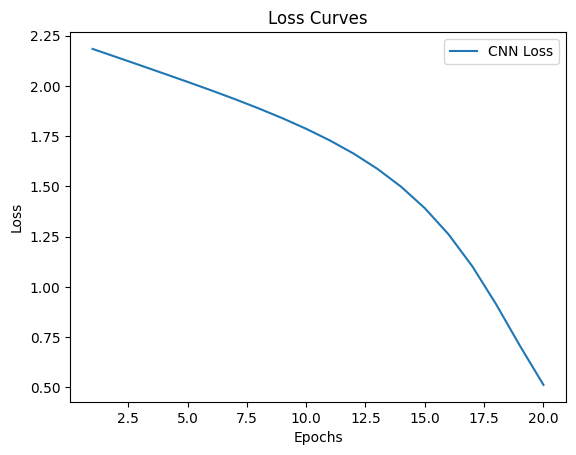

In [25]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1, len(cnn_losses) + 1), cnn_losses, label="CNN Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves")
plt.show()

Saving model:

In [26]:
torch.save(cnn.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    counter = 0
    with torch.no_grad():
        for batch, data in enumerate(dataloader):
            X, y = data['image'].to(device), data['label'].to(device)
            pred = model(X)
            y = torch.argmax(y, dim=1)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            counter += 1
    accuracy = correct / size

    print("Correct: ", correct)
    print("Size: ", size)
    print(accuracy)

In [53]:
# Initializing testing dataset and loader.
test_dataset = MultiClassDataset(label_csv_file=TESTING_LABELS, image_directory=TESTING_DIRECTORY, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64)

print("Testing Convolutional Neural Network Accuracy")
cnn_accuracy = test(test_loader, cnn, loss_fn)

Testing Convolutional Neural Network Accuracy


C:\Users\Danie\AppData\Local\Temp\ipykernel_29948\4074253306.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_label = torch.tensor(image_label, dtype=torch.long)  # Ensure it's a single integer


Predictions:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Actual:  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Length of y:  64


KeyboardInterrupt: 